In [65]:
import csv
# import findspark
# findspark.init()
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
import pyspark.sql.functions as F
from pyspark.sql.functions import lit
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)
import re
import folium
import matplotlib.pyplot as plt

## Set Up

In [66]:
metadata_file = spark.read.format("csv").option("header", "true").load("Movies/movies_metadata.csv")
credits_file = spark.read.format("csv").option("header", "true").load("Movies/credits.csv")
babynames_national = spark.read.format("csv").option("header", "true").load("Babynames/NationalNames.csv")
babynames_state = spark.read.format("csv").option("header", "true").load("Babynames/StateNames.csv")

## Clean up 

In [67]:
metadata_movies_start = metadata_file.select("id", "title", "original_language", "genres", "release_date", "belongs_to_collection", "popularity")

In [68]:
#Delete null values
metadata_movies_filtered = metadata_movies_start.filter(metadata_movies_start.id.isNotNull()).filter(metadata_movies_start.release_date.isNotNull()).filter(metadata_movies_start.title.isNotNull()).filter(metadata_movies_start.original_language.isNotNull()).filter(metadata_movies_start.genres.isNotNull()).filter(metadata_movies_start.popularity.isNotNull())
split_col = F.split(metadata_movies_filtered['belongs_to_collection'], ',')

#collection
metadata_movies_filtered = metadata_movies_filtered.withColumn('name_collection_name', split_col.getItem(1))
metadata_movies_filtered = metadata_movies_filtered.select('id', 'title', 'original_language', 'genres', 'release_date', 'name_collection_name', 'popularity')
split_col = F.split(metadata_movies_filtered['name_collection_name'], ':')
metadata_movies_filtered = metadata_movies_filtered.withColumn('collection_name_with', split_col.getItem(1))
split_col = F.split(metadata_movies_filtered['collection_name_with'], '\'')
metadata_movies_filtered = metadata_movies_filtered.withColumn('collection_name', split_col.getItem(1))
metadata_movies_filtered = metadata_movies_filtered.select("id", "title", "original_language", "genres", "release_date", "collection_name", "popularity")

#original_language
metadata_movies_languagefilter = metadata_movies_filtered.filter(F.col('original_language').rlike("^[a-z][a-z]$"))
metadata_movies_filtered = metadata_movies_languagefilter

#released
split_col = F.split(metadata_movies_filtered['release_date'], '-')
metadata_movies_filtered = metadata_movies_filtered.withColumn('released', split_col.getItem(0))
metadata_movies_filtered = metadata_movies_filtered.filter(F.col('released').rlike("^[0-9]{4}$"))
metadata_movies_filtered = metadata_movies_filtered.select('id', 'title', 'original_language', 'genres', 'released', 'collection_name', 'popularity')

#Popularity
metadata_movies_filtered = metadata_movies_filtered.filter(F.col('popularity').rlike("^[0-9]*\.?[0-9]+$"))

#ID
metadata_movies_filtered = metadata_movies_filtered.filter(F.col('id').rlike("^[0-9]+"))

#Title
metadata_movies_filtered = metadata_movies_filtered.filter(F.col('title').rlike("^[A-Z]|[0-9]|[a-z]"))

#Genres
split_genres = F.split(metadata_movies_filtered['genres'], '},')
metadata_movies_filtered = metadata_movies_filtered.withColumn("genresize", F.size(split_genres))

result = metadata_movies_filtered.filter(metadata_movies_filtered.genresize > 0).collect()

movies = []

for r in result:
    genres = ""
    movie_id = r[0]
    title = r[1]
    original_language = r[2]
    genres_complete = r[3]
    released = r[4]
    collection = r[5]
    popularity = r[6]
    
    if genres_complete != "[]": 
        genres_split = genres_complete.split('},')


        i = 0
        for genre in genres_split:
            genre_name = genre.split(',')[1].split(':')[1].split('\'')[1]

            genres += genre_name
            if i < len(genres_split)-1:
                genres += ", "
            i += 1
        movies.append((movie_id, title, original_language, genres, released, collection, popularity))


metadata_movies = sqlContext.createDataFrame(movies, ('movie_id', 'title', 'original_language', 'genres', 'released', 'collection', 'popularity'))

In [69]:
# Credits clean up
split_cast = F.split(credits_file['cast'], '},')
credits_file = credits_file.withColumn('cast_size', F.size(split_cast))

result = credits_file.filter(credits_file.cast_size > 0).collect()

cast_row = []

for r in result:
    actor = ""
    character = ""
    gender = ""
    movie_id = r[2]
    
    cast_complete = r[0]
    
    if cast_complete != "[]":
        cast_split = cast_complete.split('},')
        
        for cast in cast_split:
            if(len(cast.split(',')) > 7):
                character = cast.split('\'')[5]
                actor = cast.split('\'')[17]
                gender = cast.split('\'')[12].split(': ')[1].split(',')[0]
                
                if("(voice)" in character):
                    character = character.split(" ")[0]
                
                if(gender == "1"):
                    gender = "F"
                elif(gender == "2"):
                    gender = "M"
                else:
                    gender = "Undefined"
            
                cast_row.append((movie_id, character, actor, gender))

credits = sqlContext.createDataFrame(cast_row, ('movie_id', 'character', 'actor', 'gender'))
credits = credits.filter(F.col('movie_id').rlike("^[0-9]+"))


In [70]:
metadata_movies.show()

+--------+--------------------+-----------------+--------------------+--------+--------------------+----------+
|movie_id|               title|original_language|              genres|released|          collection|popularity|
+--------+--------------------+-----------------+--------------------+--------+--------------------+----------+
|     862|           Toy Story|               en|Animation, Comedy...|    1995|Toy Story Collection| 21.946943|
|    8844|             Jumanji|               en|Adventure, Fantas...|    1995|                null| 17.015539|
|   15602|    Grumpier Old Men|               en|     Romance, Comedy|    1995|Grumpy Old Men Co...|   11.7129|
|   11862|Father of the Bri...|               en|              Comedy|    1995|Father of the Bri...|  8.387519|
|     949|                Heat|               en|Action, Crime, Dr...|    1995|                null| 17.924927|
|   11860|             Sabrina|               en|     Comedy, Romance|    1995|                null|  6.

In [71]:
credits.show()

+--------+--------------------+------------------+---------+
|movie_id|           character|             actor|   gender|
+--------+--------------------+------------------+---------+
|    8844|        Alan Parrish|    Robin Williams|        M|
|    8844|Samuel Alan Parri...|     Jonathan Hyde|        M|
|    8844|        Judy Sheperd|     Kirsten Dunst|        F|
|    8844|      Peter Shepherd|    Bradley Pierce|Undefined|
|    8844|       Sarah Whittle|       Bonnie Hunt|        F|
|    8844|       Nora Shepherd|     Bebe Neuwirth|        F|
|    8844|        Carl Bentley|  David Alan Grier|        M|
|    8844|  Carol Anne Parrish| Patricia Clarkson|        F|
|    8844|Alan Parrish (young)|    Adam Hann-Byrd|Undefined|
|    8844|Sarah Whittle (yo...|  Laura Bell Bundy|        F|
|    8844|        Exterminator|       James Handy|        M|
|    8844|Mrs. Thomas the R...|    Gillian Barber|        F|
|    8844|            Benjamin|     Brandon Obray|        M|
|    8844|              

In [72]:
babynames_national.show()

+---+---------+----+------+-----+
| Id|     Name|Year|Gender|Count|
+---+---------+----+------+-----+
|  1|     Mary|1880|     F| 7065|
|  2|     Anna|1880|     F| 2604|
|  3|     Emma|1880|     F| 2003|
|  4|Elizabeth|1880|     F| 1939|
|  5|   Minnie|1880|     F| 1746|
|  6| Margaret|1880|     F| 1578|
|  7|      Ida|1880|     F| 1472|
|  8|    Alice|1880|     F| 1414|
|  9|   Bertha|1880|     F| 1320|
| 10|    Sarah|1880|     F| 1288|
| 11|    Annie|1880|     F| 1258|
| 12|    Clara|1880|     F| 1226|
| 13|     Ella|1880|     F| 1156|
| 14| Florence|1880|     F| 1063|
| 15|     Cora|1880|     F| 1045|
| 16|   Martha|1880|     F| 1040|
| 17|    Laura|1880|     F| 1012|
| 18|   Nellie|1880|     F|  995|
| 19|    Grace|1880|     F|  982|
| 20|   Carrie|1880|     F|  949|
+---+---------+----+------+-----+
only showing top 20 rows



In [73]:
babynames_state.show()

+---+---------+----+------+-----+-----+
| Id|     Name|Year|Gender|State|Count|
+---+---------+----+------+-----+-----+
|  1|     Mary|1910|     F|   AK|   14|
|  2|    Annie|1910|     F|   AK|   12|
|  3|     Anna|1910|     F|   AK|   10|
|  4| Margaret|1910|     F|   AK|    8|
|  5|    Helen|1910|     F|   AK|    7|
|  6|    Elsie|1910|     F|   AK|    6|
|  7|     Lucy|1910|     F|   AK|    6|
|  8|  Dorothy|1910|     F|   AK|    5|
|  9|     Mary|1911|     F|   AK|   12|
| 10| Margaret|1911|     F|   AK|    7|
| 11|     Ruth|1911|     F|   AK|    7|
| 12|    Annie|1911|     F|   AK|    6|
| 13|Elizabeth|1911|     F|   AK|    6|
| 14|    Helen|1911|     F|   AK|    6|
| 15|     Mary|1912|     F|   AK|    9|
| 16|    Elsie|1912|     F|   AK|    8|
| 17|    Agnes|1912|     F|   AK|    7|
| 18|     Anna|1912|     F|   AK|    7|
| 19|    Helen|1912|     F|   AK|    7|
| 20|   Louise|1912|     F|   AK|    7|
+---+---------+----+------+-----+-----+
only showing top 20 rows



## Data

In [74]:
inner_join = babynames_state.join(credits, babynames_state.Name == credits.character)
inner_join.show()

+------+-----+----+------+-----+-----+--------+---------+----------------+------+
|    Id| Name|Year|Gender|State|Count|movie_id|character|           actor|gender|
+------+-----+----+------+-----+-----+--------+---------+----------------+------+
| 97585|Abner|1916|     M|   AL|    6|   42040|    Abner|     John Castle|     M|
| 97585|Abner|1916|     M|   AL|    6|   95504|    Abner|     Peter Miles|     M|
| 97585|Abner|1916|     M|   AL|    6|    2734|    Abner|Richard Ashcroft|     M|
| 98654|Abner|1918|     M|   AL|    5|   42040|    Abner|     John Castle|     M|
| 98654|Abner|1918|     M|   AL|    5|   95504|    Abner|     Peter Miles|     M|
| 98654|Abner|1918|     M|   AL|    5|    2734|    Abner|Richard Ashcroft|     M|
| 99642|Abner|1920|     M|   AL|    8|   42040|    Abner|     John Castle|     M|
| 99642|Abner|1920|     M|   AL|    8|   95504|    Abner|     Peter Miles|     M|
| 99642|Abner|1920|     M|   AL|    8|    2734|    Abner|Richard Ashcroft|     M|
|100283|Abner|19

In [75]:
movie = metadata_movies.filter(metadata_movies.collection.contains("Harry Potter")).orderBy('released', ascending=True)
movie.show()

+--------+--------------------+-----------------+--------------------+--------+--------------------+----------+
|movie_id|               title|original_language|              genres|released|          collection|popularity|
+--------+--------------------+-----------------+--------------------+--------+--------------------+----------+
|     671|Harry Potter and ...|               en|Adventure, Fantas...|    2001|Harry Potter Coll...| 38.187238|
|     672|Harry Potter and ...|               en|Adventure, Fantas...|    2002|Harry Potter Coll...| 29.741452|
|     673|Harry Potter and ...|               en|Adventure, Fantas...|    2004|Harry Potter Coll...| 28.460276|
|     674|Harry Potter and ...|               en|Adventure, Fantas...|    2005|Harry Potter Coll...| 24.903058|
|     675|Harry Potter and ...|               en|Adventure, Fantas...|    2007|Harry Potter Coll...|   21.3643|
|     767|Harry Potter and ...|               en|Adventure, Fantas...|    2009|Harry Potter Coll...| 19.

In [76]:
movie_released = [int(row.released) for row in movie.select('released').collect()]
print(movie_released)

[2001, 2002, 2004, 2005, 2007, 2009, 2010, 2011]


Jaren vanaf de 5 jaar voor de release tot 5 jaar na de release

In [77]:
years = [ x for x in range(movie_released[0] - 5, movie_released[len(movie_released)-1]+5)]
print(years)

[1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]


In [78]:
movie_id = [int(row.movie_id) for row in movie.select('movie_id').collect()]
print(movie_id)

[671, 672, 673, 674, 675, 767, 12444, 12445]


In [79]:
movie_credits = credits.where(F.col("movie_id").isin(movie_id)).dropDuplicates(['character'])
character_split = F.split(movie_credits['character'], ' ')
movie_credits = movie_credits.withColumn("character", character_split.getItem(0))
movie_credits.show()

+--------+---------+-----------------+---------+
|movie_id|character|            actor|   gender|
+--------+---------+-----------------+---------+
|   12445|  Astoria|      Jade Gordon|        F|
|   12445|   Horace|    Jim Broadbent|        M|
|   12445|   Pomona| Miriam Margolyes|        F|
|   12445|      Ron|     Rupert Grint|        M|
|   12445|  Severus|     Alan Rickman|        M|
|   12445|    Katie|Georgina Leonidas|        F|
|   12445|      Mr.|        John Hurt|        M|
|   12445|    Padma|      Afshan Azad|        F|
|   12445|   George|    Oliver Phelps|        M|
|   12445| Kingsley|    George Harris|        M|
|   12445|     Twin|       Ruby Evans|Undefined|
|   12445|   Cormac|   Freddie Stroma|        M|
|   12445|   Alecto|      Suzie Toase|Undefined|
|   12445|    James|        Will Dunn|Undefined|
|   12445|    Pansy|   Scarlett Byrne|        F|
|   12445|    Giant|    Philip Wright|Undefined|
|   12445|   Fenrir|      Dave Legeno|        M|
|   12445|  Minerva|

In [80]:
# luke_table = babynames_national.filter(babynames_national.Name.like("Luke"))
# luke_table = luke_table.filter(F.col('Year').isin(years))
# luke_table = luke_table.groupBy('Year', 'Year').agg(F.sum('Count').alias('Count')).orderBy('Year')

# luke_count = [int(row.Count) for row in luke_table.select('Count').collect()]
# years = [int(row.Year) for row in luke_table.select('Year').collect()]
# fig = plt.figure(figsize=(15, 5))
# plt1 = fig.add_subplot(121)
# plt1.plot(years, luke_count)

In [81]:
movie_characters = [row.character for row in movie_credits.select('character').collect()]
movie_babynames_table = babynames_national.where(F.col("Name").isin(movie_characters)).where(F.col('Year').isin(years))
movie_babynames_table = movie_babynames_table.groupBy('Year', 'Year').agg(F.sum('Count').alias('Count')).orderBy('Year')

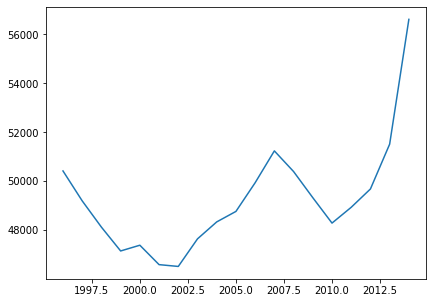

In [82]:
babynames_count = [int(row.Count) for row in movie_babynames_table.select('Count').collect()]
years = [int(row.Year) for row in movie_babynames_table.select('Year').collect()]
fig = plt.figure(figsize=(15,5))
plt1 = fig.add_subplot(121)
plt1.plot(years, babynames_count)

In [92]:
popular_movies = metadata_movies.filter(metadata_movies.popularity > 15).orderBy('popularity').limit(7)
pop_movies_id = [155,166426,680,271110,281338,131631,210577]
popular_movie_credits = credits.where(F.col("movie_id").isin(pop_movies_id)).dropDuplicates(['character'])
select_popular_movies = popular_movies.where(F.col("movie_id").isin(pop_movies_id))
character_split = F.split(popular_movie_credits['character'], ' ')
popular_movie_credits = popular_movie_credits.withColumn("character", character_split.getItem(0))
#popular_movie_credits.show()
#popular_movies.show()


+--------+---------+--------------------+---------+
|movie_id|character|               actor|   gender|
+--------+---------+--------------------+---------+
|  281338|     Lang|Mercedes de la Zerda|Undefined|
|  281338|      The|     Woody Harrelson|        M|
|  281338|     Lake|        Sara Canning|        F|
|  281338|   Rocket|        Terry Notary|Undefined|
|  281338|    Boyle|           Chad Rook|        M|
|  281338|     Blue|     Max Lloyd-Jones|        M|
|  281338|  Maurice|       Karin Konoval|        F|
|  281338|    Elder|      Timothy Webber|        M|
|  281338| Cornelia|          Judy Greer|        F|
|  281338|     Nova|        Amiah Miller|        F|
|  281338|Cornelius|        Devyn Dalton|Undefined|
|  281338|      Bad|          Steve Zahn|        M|
|  281338|     Koba|        Toby Kebbell|        M|
|  281338|    Spear|  Alessandro Juliani|        M|
|  281338|     Luca| Michael Adamthwaite|        M|
|  281338| Preacher|   Gabriel Chavarria|Undefined|
|  281338|  

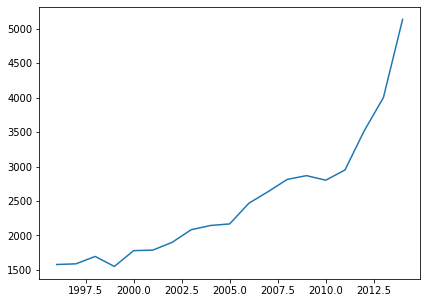

In [101]:
popular_movie_characters = [row.character for row in popular_movie_credits.select('character').collect()]
specific_babynames_table = babynames_national.where(F.col("Name").isin(popular_movie_characters)).where(F.col('Year').isin(years))
specific_babynames_table = specific_babynames_table.groupBy('Year', 'Year').agg(F.sum('Count').alias('Count')).orderBy('Year')
specific_names_count = [int(row.Count) for row in specific_babynames_table.select('Count').collect()]
specific_names_years = [int(row.Year) for row in specific_babynames_table.select('Year').collect()]
specific_names_fig = plt.figure(figsize=(15,5))
specific_names_graph = specific_names_fig.add_subplot(121)
specific_names_graph.plot(specific_names_years, specific_names_count)